In [1]:
# Import Required Packages
from qiskit import IBMQ
from pytket import Circuit, Qubit, Bit
from sympy import symbols
from pytket.circuit.display import render_circuit_jupyter

from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.drivers import Molecule
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.drivers import UnitsType
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit_nature.circuit.library.ansatzes import UCCSD
from qiskit.algorithms.optimizers import SLSQP
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.settings import settings
import openfermion as of

from pytket.pauli import Pauli, QubitPauliString
from pytket.utils.operators import QubitPauliOperator
from pytket.passes import OptimisePhaseGadgets, SequencePass
from pytket.predicates import CompilationUnit
from pytket.utils import append_pauli_measurement
from pytket.utils import expectation_from_shots
from pytket.extensions.qiskit import IBMQEmulatorBackend, AerBackend

from scipy.optimize import dual_annealing

settings.dict_aux_operators = True
IBMQ.save_account("IBM Key")
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

configrc.store_credentials:WARNING:2022-08-23 20:28:56,325: Credentials already present. Set overwrite=True to overwrite.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
# define the molecule
def getProblem(dist):
    molecule = Molecule(
        # coordinates are given in Angstrom
        geometry=[["Li", [0.0, 0.0, 0.0]],["H", [0.0, 0.0, dist]],],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    # the driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )

    problem = ElectronicStructureProblem(driver)


    # this will call driver.run() internally
    second_q_ops = problem.second_q_ops()


    # the transformer to reduce the complexity
    transformer = ActiveSpaceTransformer(
        num_electrons=2,
        num_molecular_orbitals=3,
    )

    problem_reduced = ElectronicStructureProblem(driver, [transformer])
    second_q_ops_reduced = problem_reduced.second_q_ops()
    hamiltonian_reduced = second_q_ops_reduced['ElectronicEnergy']

    mapper = ParityMapper()
    converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

    return problem_reduced, converter

In [3]:
# Run VQE and get the ground state energy
def getGroundEnergy(problem, converter, backend, optimizer):
    vqe_factory = VQEUCCFactory(
        quantum_instance=backend,
        optimizer=optimizer,
    )
    solver = GroundStateEigensolver(converter, vqe_factory)
    result = solver.solve(problem)
    return result

In [4]:
# Calculate the theoretical total energies, and the offset energies
tot_energy = []
offset_energies = []
atomic_distance = np.linspace(0.5, 3.9, 20)
for i in atomic_distance:
    problem, converter = getProblem(i)
    energy = getGroundEnergy(problem,converter,StatevectorSimulator(),SLSQP())
    tot_energy.append(energy.total_energies)
    offset_energies.append(energy.nuclear_repulsion_energy + energy.extracted_transformer_energy)

In [5]:
# Get the Hamtiltonian matrices for VQE
hams = []

for i in atomic_distance:
    molecule = Molecule(
            # coordinates are given in Angstrom
            geometry=[["Li", [0.0, 0.0, 0.0]],["H", [0.0, 0.0, i]],],
            multiplicity=1,  # = 2*spin + 1
            charge=0,
        )
        # the driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )

    problem = ElectronicStructureProblem(driver)


    # this will call driver.run() internally
    second_q_ops = problem.second_q_ops()


    # the transformer to reduce the complexity
    transformer = ActiveSpaceTransformer(
        num_electrons=2,
        num_molecular_orbitals=3,
    )

    problem_reduced = ElectronicStructureProblem(driver, [transformer])
    second_q_ops_reduced = problem_reduced.second_q_ops()
    hamiltonian_reduced = second_q_ops_reduced['ElectronicEnergy']
    particle_number = problem_reduced.grouped_property_transformed.get_property("ParticleNumber")
    num_spin_orbitals = particle_number.num_spin_orbitals
    num_particles = particle_number.num_particles

    mapper = ParityMapper()
    converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

    qubit_op = converter.convert(hamiltonian_reduced, num_particles=problem_reduced.num_particles)
    ham = qubit_op.to_matrix()
    hams.append(ham)

In [6]:
pauli_sym = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

In [7]:
def qps_from_openfermion(paulis):
    """Convert OpenFermion tensor of Paulis to pytket QubitPauliString."""
    qlist = []
    plist = []
    for q, p in paulis:
        qlist.append(Qubit(q))
        plist.append(pauli_sym[p])
    return QubitPauliString(qlist, plist)

In [8]:
def qpo_from_openfermion(openf_op):
    """Convert OpenFermion QubitOperator to pytket QubitPauliOperator."""
    tk_op = dict()
    for term, coeff in openf_op.terms.items():
        string = qps_from_openfermion(term)
        tk_op[string] = coeff
    return QubitPauliOperator(tk_op)

In [9]:
def compiler_pass(backend):
    return SequencePass([OptimisePhaseGadgets(), backend.default_compilation_pass()])

In [10]:
def gen_pauli_measurement_circuits(state_circuit, compiler_pass, operator):
    # compile main circuit once
    state_cu = CompilationUnit(state_circuit)
    compiler_pass.apply(state_cu)
    compiled_state = state_cu.circuit
    final_map = state_cu.final_map
    # make a measurement circuit for each pauli
    pauli_circuits = []
    coeffs = []
    energy = 0
    for p, c in operator.terms.items():
        if p == ():
            # constant term
            energy += c
        else:
            # make measurement circuits and compile them
            pauli_circ = Circuit(state_circuit.n_qubits - 1)  # ignore syndrome qubit
            append_pauli_measurement(qps_from_openfermion(p), pauli_circ)
            pauli_cu = CompilationUnit(pauli_circ)
            compiler_pass.apply(pauli_cu)
            pauli_circ = pauli_cu.circuit
            init_map = pauli_cu.initial_map
            # map measurements onto the placed qubits from the state
            rename_map = {
                i: final_map[o] for o, i in init_map.items() if o in final_map
            }
            pauli_circ.rename_units(rename_map)
            state_and_measure = compiled_state.copy()
            state_and_measure.append(pauli_circ)
            pauli_circuits.append(state_and_measure)
            coeffs.append(c)
    return pauli_circuits, coeffs, energy

In [11]:
# Calculate energy expeaction value with <Psi|H|Psi>
def expectation_value(state_circuit, hamil, backend, n_shots):
    if backend.supports_expectation:
        circuit = state_circuit.copy()
        compiled_circuit = backend.get_compiled_circuit(circuit)
        final_state = compiled_circuit.get_statevector()
        expt = np.transpose(final_state) @ hamil @ np.transpose(final_state).real
        return expt
    else:
        raise NotImplementedError("Implementation for state and counts to be written")

In [12]:
# Define VQE Cost Function
def vqeCost(arg):
    # Build Ansatz
    ansatz = Circuit()
    qubits = ansatz.add_q_register("q", 4)
    symstring = ['a' + str(x) for x in range(24)]
    args = symbols(symstring)
    for i in range(4):
        ansatz.Rz(args[3*i], qubits[i])
        ansatz.Rx(args[3*i+1], qubits[i])
        ansatz.Rz(args[3*i+2], qubits[i])
    ansatz.CX(qubits[0], qubits[2])
    ansatz.CX(qubits[1], qubits[0])
    ansatz.CX(qubits[1], qubits[3])
    for i in range(4):
        ansatz.Rz(args[3*i+12], qubits[i])
        ansatz.Rx(args[3*i+13], qubits[i])
        ansatz.Rz(args[3*i+14], qubits[i])
    ansatz.measure_all()
    
    ansatz.symbol_substitution(dict(zip(args, arg)))
    ansatz.rename_units({Qubit("synq", 0): Qubit("q", 5)})
    
    # Change hams index for another interatomic distance
    energy = expectation_value(ansatz, hams[0], AerBackend(), 8000).real
    costfunc.append(energy)
    print(energy)
    return energy

In [13]:
# Run VQE
costfunc = []

results = dual_annealing(vqeCost, x0=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                     bounds=([-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]
                             , [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi],
                            [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]
                             , [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi],
                            [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]
                             , [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]), maxiter=200)



-0.8613605883652207
-0.25171620293495744
-0.3903869757649234
-0.08257338189448064
-0.2560615983546729
-0.18641558539118508
-0.3528198968251719
-0.21977408361443207
-0.2717261099124883
-0.31367318558436297
-0.3541683982737711
-0.20180302937138692
-0.13715339658357353
-0.037057009874132484
-0.27282254675510087
-0.302961948788001
-0.19648033966480555
-0.37556945324195157
-0.45424114696130624
-0.28091595267741276
-0.3486814912832099
-0.20794014266124564
-0.24076589611728663
0.01599379543089012
-0.2875275330854184
-0.2907311175964269
-0.3205991418729978
-0.4529732430931003
-0.2518788428502706
0.039784756854152115
-0.23993683825065099
-0.2598676696823021
-0.24435195527242526
-0.24260156774654762
-0.30772364917293615
-0.39468902251063903
-0.37511740169572294
-0.296761115654798
-0.2722172727662543
-0.2722172727662543
-0.24462359813045892
-0.09478788303548202
-0.09478788303548202
-0.23769693489108373
-0.2077255490919711
-0.2077255490919711
-0.21877293748162288
-0.25463496895836335
-0.2546349689

-0.2644863164758902
-0.3546514292266991
-0.2908591621412111
-0.3061236026972878
-0.32142111167184134
-0.3216433027685989
-0.26809534266478796
-0.291884967954098
-0.348459179415862
-0.3400205645651905
-0.30103197208976484
-0.14465583349235295
-0.28592207943318987
-0.33193263622321856
-0.370813054054264
-0.370813054054264
-0.354475946771197
-0.18317355441450645
-0.18317355441450645
-0.20284056732711866
-0.20169041478223734
-0.20169041478223734
-0.13462649835610643
-0.4675086779363861
-0.4675086779363861
-0.37157266992814675
-0.5417695823483117
-0.23693461028980486
-0.45270640622888014
-0.5753473428447876
-0.5383605747679407
-0.3314127371464404
-0.24411297916085217
-0.22666764823083496
-0.460750680013274
-0.31644132681271403
-0.2025920053089549
-0.35583227592116573
0.0657972311333642
-0.48900223805130666
-0.09866914627363953
-0.37015211827914113
-0.2586812582355636
-0.1890798079868223
-0.297206568248336
-0.29605557813790256
-0.18128996122920124
-0.32113500288165314
-0.22752784340355903
-0

-0.36089161910666356
-0.3021555429001648
-0.303024066631826
-0.3116429200487023
-0.279773989195561
-0.3947296099387069
-0.22609802198844497
-0.388704599530575
-0.36491506042820476
-0.16679270015843572
-0.36953231909927137
-0.2915721179753201
-0.29939237771759436
-0.41227048360146484
-0.2952332522928002
-0.2782043887438178
-0.35979381065472515
-0.3503259001765089
-0.3324018295015052
-0.3777579273064896
-0.32915413850323905
-0.31414955815533324
-0.3805075126191158
-0.42111421262395005
-0.38455610291624653
-0.38462472692012606
-0.4145186814053063
-0.31387751515999074
-0.3295937110541571
-0.328729354013866
-0.2615420280480071
-0.2615420280480071
-0.3525633226117957
-0.3183923939564126
-0.3183923939564126
-0.2920940297704339
-0.3020648253598101
-0.3020648253598101
-0.27008665749783445
-0.25822437408200566
-0.25822437408200566
-0.22449120706708992
-0.16895799440278536
-0.2373029044756943
-0.5019607620095492
-0.03465307286048845
-0.23331292784741553
-0.3098031173395931
-0.12732496749714403
-0

-0.24264543348592837
-0.17908205146212489
-0.11220655900341892
-0.4085130422763078
-0.2615961900309929
-0.27959809104382577
-0.3166835353033468
-0.6145914108021803
-0.5879438880550034
-0.44435861398763155
-0.39283260776631634
-0.1408663186007266
-0.1743798678227313
-0.4340341247153123
-0.42273000259056626
-0.46703778916625927
-0.5415044094476218
-0.5118406707582948
-0.3922195934552566
-0.5118406707582948
-0.46744604752717234
-0.17566424918487933
-0.46744604752717234
-0.3471888359545855
-0.47409663443165706
-0.47409663443165706
-0.5089550945108997
-0.5127083554043679
-0.5127083554043679
-0.048058368806940296
-0.2892420091388053
-0.1829681851258661
-0.409939312457105
-0.1732863702533912
-0.24217174795989055
-0.2290041605210101
-0.13576845780954097
-0.3293332975747821
-0.3711757924550137
-0.3247129376048628
-0.0865673332870983
-0.43680542764819297
-0.28607670726692974
-0.20781186735071738
-0.25442785452235994
-0.20160878583172565
-0.20718662223590245
-0.3659030598183431
-0.216636370630240

-0.9663093897020467
-0.9663093901375277
-0.9663093903639504
-0.9663093897020465
-0.966309390173011
-0.9663093897036727
-0.9663093897020465
-0.9663093901177378
-0.966309390330974
-0.9663093897020465
-0.9663093898810583
-0.9663093901967328
-0.9663093903623219
-0.9663093902808308
-0.966309390033109
-0.9663093897036727
-0.9663093898260051
-0.966309390033109
-0.9663093897353335
-0.9663093897594492
-0.966309390033109
-0.966309390194744
-0.9663093905100865
-0.966309390033109
-0.9665550100841791
-0.9665550100084982
-0.9665550101913817
-0.9665550101597211
-0.9665550100084987
-0.9665550102910915
-0.966555010011391
-0.9665550100084986
-0.9665550099899036
-0.9665550101427446
-0.9665550100084982
-0.9665550101131234
-0.9665550100541079
-0.9665550101568241
-0.9665550102507432
-0.9665550100841791
-0.966555010011391
-0.9665550100082272
-0.9665550100841791
-0.9665550100257031
-0.9665550097345376
-0.9665550100841791
-0.9665550100506737
-0.9665550102701383
-0.9665550100841791
-0.9668831043461186
-0.966883

-0.3421775838151158
-0.3673145786976272
-0.2514394162791776
-0.17987637622369995
-0.3975170026406294
-0.3062351749736142
-0.3129625828738394
-0.23626766912131744
-0.3105778870995808
-0.4347725668995722
-0.25559062442671326
-0.22943830710044877
-0.37043358724569103
-0.352247647560024
-0.1398166038232192
-0.3833503932908149
-0.381233549148575
-0.10626659531098158
-0.6969334857952721
-0.858493351788217
-0.6435855844823153
-0.7926936330955496
-0.4277937748395752
-0.14393497296691385
-0.8495570856584074
-0.6924270829202461
-0.898808330553313
-0.9088510020183167
-0.49621906666310944
-0.6902542828041354
-0.8297392648161547
-0.9088510020183167
-0.05425033997052344
-0.14152082970264562
-0.9088510020183167
-0.5757335123775832
-0.6720581564172472
-0.9088510020183167
-0.5686484800581401
-0.5445375314774882
-0.9088510020183167
-0.18838731726032504
-0.048643638989221305
-0.15452888550490793
-0.5480238310026947
-0.21475089406934916
-0.31975866524604446
-0.2553802427810105
-0.4428482477680651
-0.24117

-0.33193285930824135
-0.06173986328230049
-0.4892489103362967
-0.7166778024820667
-0.5402017304276338
-0.8452832927698322
-0.8295802017066287
-0.11385573581461532
-0.5409984913809269
-0.3940288109362462
-0.008128917236820568
-0.8429197570361714
-0.5976983947366971
-0.7524085851968245
-0.5795163830564458
-0.9395785627155191
-0.9411793430812887
-0.05412090354395859
-0.9411793430812887
-0.928538258869352
-0.04157454474443034
-0.9411793430812887
-0.1854965988941098
-0.920733239377241
-0.9411793430812887
-0.11575184595868711
-0.2221492530744004
-0.46608336603266753
-0.043748639294877954
-0.263428065911348
-0.24962210079481315
-0.3285001848022807
-0.4495974526794563
-0.2910873965837664
-0.40764982669983235
-0.3195194986240738
-0.4185163122911608
-0.40478044461426654
-0.32286038442416937
-0.3840604917652638
-0.31702553615595175
-0.2241062212701685
-0.319155461372858
-0.32385645053627166
-0.32560575927828944
-0.342816983231903
-0.41827681647185344
-0.32495052725127704
-0.37031540901583276
-0.9

-0.06105063431202433
-0.2938713446803772
-0.2181097597724717
-0.2984070205197821
-0.2997169494990501
0.03087372030473784
-0.31098814298868294
-0.28636221966130626
-0.28978900372691113
-0.4297734573855367
-0.2793447005713159
-0.31009309924562595
-0.27865025494047535
-0.3947125056561446
-0.40364972762715456
-0.33349504068873204
-0.23864868779397372
-0.30919956026735823
-0.3228308887988789
-0.27255804289649205
-0.16794218564902935
-0.27116599852396484
-0.7415411131744281
-0.014582952755934343
-0.2978850790721779
-0.16584679311867678
-0.6645284810951246
-0.26449332753363863
-0.8477215737903279
-0.003611849617834632
-0.5828437552823672
-0.8636406119192461
-0.9093965709363787
-0.859240743217047
-0.9162263491496525
-0.7520324283350911
-0.9453199409459712
-0.8308609676493576
-0.6833240933829929
-0.9453199409459712
-0.0492127551854134
-0.00988699790589111
-0.9453199409459712
-0.624148774990902
-0.8977546941628824
-0.9453199409459712
-0.32695545845676566
-0.36316001804237763
-0.36965910860039464

-0.2587328208070065
-0.34425624952594436
-0.2092984807911719
-0.41416533202197703
-0.3562743961318581
-0.3275376991678719
-0.4137108321989861
-0.19547358443101978
-0.16560755033311186
-0.5123514078254222
-0.24956130152217584
-0.2112830570952015
-0.34014224544664556
-0.3572599941000084
-0.20190795757470575
-0.2328937715196735
-0.42059684711917233
-0.0975788362923602
-0.2918995711489998
-0.22289415289261783
-0.2446921094291079
-0.15377579734200583
-0.5661007302929485
0.04547360519455754
-0.2992235348948335
-0.007186861354952022
-0.9579905163006768
-0.5222140155932601
-0.23706945580514732
-0.08519782862208557
-0.5706430859930125
-0.031626562506161686
-0.9072819361664936
-0.9377301999729714
-0.9131523666179141
-0.32333334126175
-0.9579905163006768
-0.9026345616077159
-0.9578829595197492
-0.9578829595197492
-0.02503619497735789
-0.12027932291414807
-0.9578829595197492
-0.9461315764426868
-0.3323972110216008
-0.9578829595197492
-0.3711028655535282
-0.21398497004383216
-0.28758894490288067
-0

-0.33549865152594294
-0.3738839533704581
-0.1359203686407863
-0.3340444897662585
-0.3825120479032858
-0.3396132706113256
-0.1546449214779772
-0.180628275011964
-0.7776699724619924
-0.08970923517399781
-0.918479470853705
-0.9331856769942418
-0.9523024663653455
-0.06127249305787067
-0.6392133799878135
-0.8681891535717057
-0.2981285045789553
-0.7488994851915831
-0.4808632943073296
-0.6009175634982604
-0.443531664452308
-0.9579762199849291
-0.9579762199849291
-0.9517421786572926
-0.8728864111561013
-0.9579762199849291
-0.42442173638980996
-0.4916864390586073
-0.9579762199849291
-0.4008085618023467
-0.31928405440065605
-0.9579762199849291
-0.3216054397553531
-0.2568143679348718
-0.3232968423472402
-0.204716157702739
-0.47882219535014015
-0.27094465787626715
-0.3439071932701416
-0.12199311302893728
-0.42561089502771965
-0.35726300785081583
-0.2139583921968951
-0.14287356781002192
-0.33187612631217556
-0.555723048008961
-0.3386582882491028
-0.40311651337830195
-0.45533721512275027
-0.37408729

-0.9587109994159848
-0.31546133288796047
-0.8937007077714644
-0.9587109994159848
-0.903811019484414
-0.6476513204913071
-0.9587109994159848
-0.5410413323159085
-0.14314831876205747
-0.9587109994159848
-0.1971561780191478
-0.3064405361701106
-0.26589173199199045
-0.1720887863820307
0.24452804803505993
-0.11502623520371513
-0.32843167846222343
-0.26050276531767486
-0.2269781819089328
-0.23271783376198596
-0.236456832171962
-0.4534177514628177
-0.26666411509972215
-0.44230415152449
-0.2753529172368274
-0.38964654108637586
-0.29613002019476165
-0.33568913648847554
-0.24714414991548705
-0.4072449534403546
-0.19573855853982292
-0.25173973230246954
-0.40653368202731505
-0.26131540244713913
-0.5401195202555388
-0.7508049620308579
-0.07062369604966666
-0.8096913377528966
-0.7271956746739188
-0.8244394813101664
-0.059126456839415635
-0.8159363229211806
-0.9351275618513218
-0.7490615721822554
-0.9515203122280123
-0.5372334009484552
-0.4901393465227201
-0.7776419670339061
-0.9587109994159848
-0.86

In [14]:
# Estimated Energy for the first Hamiltonian
# Change hams index for another interatomic distance
results['fun'] + offset_energies[0]

(-7.028410094537328+0j)

In [15]:
# Calculated Energies

energy = np.array([
-7.028410094123399,
-7.452286605038468,
-7.671897740563532,
-7.784612564224606,
-7.838812828206535,
-7.86024533282158,
-7.862609407404388,
-7.853650676988547,
-7.838009887078212,
-7.8185564802860466,
-7.798455382976568,
-7.774824833383386,
-7.75254244573248,
-7.730859705115488,
-7.710242230898151,
-7.691034985005276,
-7.664663768226784,
-7.658154496925294,
-7.6435680131430095,
-7.656527695530976,
])

/opt/anaconda3/envs/pytket/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


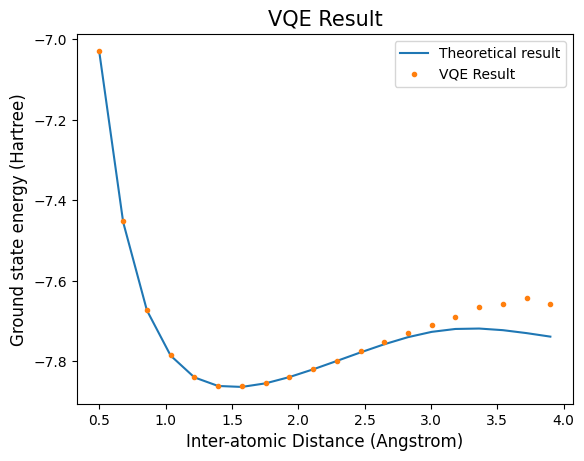

In [16]:
# Plot Results
plt.plot(atomic_distance, tot_energy, '-', label='Theoretical result')
plt.plot(atomic_distance, energy, '.', lw=2, label='VQE Result')
plt.legend()
plt.title("VQE Result", size=15)
plt.xlabel("Inter-atomic Distance (Angstrom)", size=12)
plt.ylabel("Ground state energy (Hartree)", size=12)
plt.savefig("BRUHHHHH.svg")